# 第十七次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW17-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">5月25日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

## 请认真阅读代码，理解代码的功能
### 创建变量
pytorch创建变量的语法与numpy有许多相似之处。下面列举了pytorch创建变量的一些常见用法：

In [2]:
import torch
import numpy as np

# 创建一个张量（tensor）
x = torch.tensor([1, 2, 3, 4])
print("x:", x)

# 创建一个矩阵（matrix）
y = torch.tensor([[1, 2], [3, 4]])
print("y:", y)

# 创建一个全零的张量
z = torch.zeros((2, 3))
print("z:", z)

# 创建一个随机初始化的张量
w = torch.randn((3, 3))
print("w:", w)

# pytorch tensor与numpy array的相互转换
numpy_array = np.array([1, 2, 3, 4, 5])

# 将NumPy数组转换为PyTorch张量
torch_tensor = torch.from_numpy(numpy_array)
print(torch_tensor)

# 将PyTorch张量转换为NumPy数组
numpy_array = torch_tensor.numpy()
print(numpy_array)

x: tensor([1, 2, 3, 4])
y: tensor([[1, 2],
        [3, 4]])
z: tensor([[0., 0., 0.],
        [0., 0., 0.]])
w: tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986],
        [ 0.4033,  0.8380, -0.7193]])
tensor([1, 2, 3, 4, 5], dtype=torch.int32)
[1 2 3 4 5]


### 算术运算

In [3]:
import torch

# 创建一个服从标准正态分布的3*4的张量A
A = torch.randn((3, 4))
print("A:", A)

# 创建一个服从标准正态分布的2*6的张量B
B = torch.randn((2, 6))
print("B:", B)

# 使用view操作将B的形状也转换成3*4，计算A+B和A*B^T（矩阵乘法）
B = B.view(3, 4)
print("A+B:", A + B)
print("A*B^T:", A.matmul(B.t()))

# 取出矩阵A的所有大于0的值，并按照行的顺序排列成一个一维的张量C。
# 例如：[[0, 0.1, 0.2], [-0.3, 0.4, -0.5]]需要转换成[0.1, 0.2, 0.4]
C = A[A > 0]
print("C:", C)

# 将C的每个元素平方，得到D。计算D的平均值mean(D)，并求出mean(D)对A的梯度
D = C ** 2
D = D.clone().detach().requires_grad_(True)  # 需指定requires_grad=True，否则无法求梯度
print("D:", D)
print("mean(D):", D.mean())
D.mean().backward()
print("A.grad:", A.grad)

# 将A中所有大于零的数置为零并输出
A[A > 0] = 0
print("A:", A)

# 使用detach方法将一个张量A从计算图中分离出来，并将其转换为一个不需要梯度的张量B
A = torch.randn((3, 4), requires_grad=True)
B = A.detach()
print("A.requires_grad:", A.requires_grad)
print("B.requires_grad:", B.requires_grad)

# 使用with torch.no_grad()包装一个计算过程，使得其中的计算不会被记录到计算图中
with torch.no_grad():
    C = A + 2
    print("C.requires_grad:", C.requires_grad)
    


A: tensor([[-0.4033, -0.5966,  0.1820, -0.8567],
        [ 1.1006, -1.0712,  0.1227, -0.5663],
        [ 0.3731, -0.8920, -1.5091,  0.3704]])
B: tensor([[ 1.4565,  0.9398,  0.7748,  0.1919,  1.2638, -1.2904],
        [-0.7911, -0.0209, -0.7185,  0.5186, -1.3125,  0.1920]])
A+B: tensor([[ 1.0532,  0.3432,  0.9569, -0.6648],
        [ 2.3644, -2.3616, -0.6684, -0.5872],
        [-0.3454, -0.3734, -2.8216,  0.5624]])
A*B^T: tensor([[-1.1715,  0.1341, -0.4230],
        [ 0.5827,  2.6880, -1.6161],
        [-1.3931,  2.8087,  1.3212]])
C: tensor([0.1820, 1.1006, 0.1227, 0.3731, 0.3704])
D: tensor([0.0331, 1.2113, 0.0151, 0.1392, 0.1372], requires_grad=True)
mean(D): tensor(0.3072, grad_fn=<MeanBackward0>)
A.grad: None
A: tensor([[-0.4033, -0.5966,  0.0000, -0.8567],
        [ 0.0000, -1.0712,  0.0000, -0.5663],
        [ 0.0000, -0.8920, -1.5091,  0.0000]])
A.requires_grad: True
B.requires_grad: False
C.requires_grad: False


## 基于FasionMNIST的图像分类任务

In [4]:
training_data = datasets.FashionMNIST(
    root="./", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(
    root="./", train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:22<00:00, 1154543.45it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 105660.30it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:09<00:00, 463773.00it/s] 


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



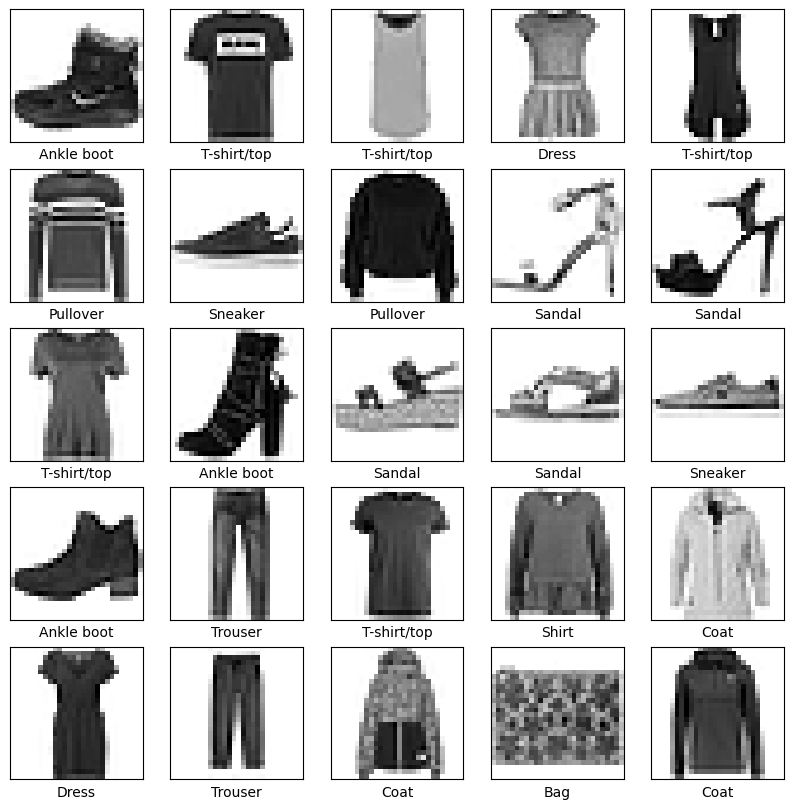

In [5]:
# 进行简单的可视化
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data[i][0].squeeze(0), cmap=plt.cm.binary)
    plt.xlabel(labels[training_data[i][1]])
plt.show()

In [6]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

In [7]:
# TODO 数据加载器(1')
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [12]:
# TODO 按照下图定义模型(2')
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(2, 3),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

<?xml version="1.0" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="192pt" height="337pt" viewBox="0.00 0.00 192.15 337">
<g id="graph0" class="graph" transform="translate(13.086503072123655,316.16394050517243) scale(0.8420629536084173)" data-name="G">

<polygon fill="white" stroke="none" points="-4,4 -4,-333 188.15,-333 188.15,4 -4,4"/>
<!-- input -->
<g id="node1" class="node" pointer-events="visible" data-name="input">

<polygon fill="none" stroke="black" points="0,-292.5 0,-328.5 184.15,-328.5 184.15,-292.5 0,-292.5"/>
<text text-anchor="middle" x="22.78" y="-306.3" font-family="Times,serif" font-size="14.00">Input</text>
<polyline fill="none" stroke="black" points="45.55,-292.5 45.55,-328.5"/>
<text text-anchor="middle" x="114.85" y="-306.3" font-family="Times,serif" font-size="14.00">(Flatten到28*28=784)</text>
</g>
<!-- fc1 -->
<g id="node2" class="node" pointer-events="visible" data-name="fc1">

<polygon fill="none" stroke="black" points="34.9,-219.5 34.9,-255.5 149.25,-255.5 149.25,-219.5 34.9,-219.5"/>
<text text-anchor="middle" x="92.08" y="-233.4" font-family="Times,serif" font-size="14.00">Linear(784→128)</text>
</g>
<!-- input&#45;&gt;fc1 -->
<g id="edge1" class="edge" data-name="input-&gt;fc1">

<path fill="none" stroke="black" d="M92.08,-292.67C92.08,-284.89 92.08,-275.44 92.08,-266.62"/>
<polygon fill="black" stroke="black" points="95.58,-266.72 92.08,-256.72 88.58,-266.72 95.58,-266.72"/>
</g>
<!-- relu -->
<g id="node3" class="node" pointer-events="visible" data-name="relu">

<polygon fill="none" stroke="black" points="65.08,-146.5 65.08,-182.5 119.08,-182.5 119.08,-146.5 65.08,-146.5"/>
<text text-anchor="middle" x="91.68" y="-160.3" font-family="Times,serif" font-size="14.00">ReLU</text>
</g>
<!-- fc1&#45;&gt;relu -->
<g id="edge2" class="edge" data-name="fc1-&gt;relu">

<path fill="none" stroke="black" d="M92.08,-219.67C92.08,-211.89 92.08,-202.44 92.08,-193.62"/>
<polygon fill="black" stroke="black" points="95.58,-193.72 92.08,-183.72 88.58,-193.72 95.58,-193.72"/>
</g>
<!-- fc2 -->
<g id="node4" class="node" pointer-events="visible" data-name="fc2">

<polygon fill="none" stroke="black" points="38.4,-73.5 38.4,-109.5 145.75,-109.5 145.75,-73.5 38.4,-73.5"/>
<text text-anchor="middle" x="92.08" y="-87.4" font-family="Times,serif" font-size="14.00">Linear(129→10)</text>
</g>
<!-- relu&#45;&gt;fc2 -->
<g id="edge3" class="edge" data-name="relu-&gt;fc2">

<path fill="none" stroke="black" d="M92.08,-146.67C92.08,-138.89 92.08,-129.44 92.08,-120.62"/>
<polygon fill="black" stroke="black" points="95.58,-120.72 92.08,-110.72 88.58,-120.72 95.58,-120.72"/>
</g>
<!-- output -->
<g id="node5" class="node" pointer-events="visible" data-name="output">

<polygon fill="none" stroke="black" points="64.63,-0.5 64.63,-36.5 119.52,-36.5 119.52,-0.5 64.63,-0.5"/>
<text text-anchor="middle" x="92.08" y="-14.3" font-family="Times,serif" font-size="14.00">Output</text>
</g>
<!-- fc2&#45;&gt;output -->
<g id="edge4" class="edge" data-name="fc2-&gt;output">

<path fill="none" stroke="black" d="M92.08,-73.67C92.08,-65.89 92.08,-56.44 92.08,-47.62"/>
<polygon fill="black" stroke="black" points="95.58,-47.72 92.08,-37.72 88.58,-47.72 95.58,-47.72"/>
</g>
</g>
</svg>

In [13]:
# TODO 创建模型，并选择合适的优化器和损失函数(1')
model = Net()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [14]:
# TODO 模型训练过程(2')
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch, (data, target) in enumerate(train_dataloader):
        #***********************************
        # 请在此处添加代码，完成模型训练过程
        logits = model(data).squeeze()
        probs = torch.softmax(logits, dim=1)
        loss = criterion(logits, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = probs.argmax(dim=1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        #***********************************
    return train_loss / len(train_dataloader), 100. * correct / total

def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (data, target) in enumerate(test_dataloader):
            #***********************************
            # 请在此处添加代码，完成模型测试过程
            logits = model(data).squeeze()

            test_loss += criterion(logits, target).item()
            total += target.size(0)
            correct += (logits.argmax(dim=1) == target).sum().item()
            #***********************************
    return test_loss / len(test_dataloader), 100. * correct / total

Epoch 1/10, Train Loss: 0.5500, Train Acc: 80.99%, Test Loss: 0.4658, Test Acc: 83.56%
Epoch 2/10, Train Loss: 0.4018, Train Acc: 85.87%, Test Loss: 0.3993, Test Acc: 85.92%
Epoch 3/10, Train Loss: 0.3615, Train Acc: 87.02%, Test Loss: 0.4061, Test Acc: 85.59%
Epoch 4/10, Train Loss: 0.3351, Train Acc: 87.89%, Test Loss: 0.3664, Test Acc: 86.54%
Epoch 5/10, Train Loss: 0.3155, Train Acc: 88.54%, Test Loss: 0.3523, Test Acc: 87.72%
Epoch 6/10, Train Loss: 0.2964, Train Acc: 89.21%, Test Loss: 0.3555, Test Acc: 87.41%
Epoch 7/10, Train Loss: 0.2851, Train Acc: 89.57%, Test Loss: 0.3569, Test Acc: 87.40%
Epoch 8/10, Train Loss: 0.2743, Train Acc: 89.90%, Test Loss: 0.3502, Test Acc: 87.66%
Epoch 9/10, Train Loss: 0.2630, Train Acc: 90.26%, Test Loss: 0.3379, Test Acc: 87.72%
Epoch 10/10, Train Loss: 0.2550, Train Acc: 90.53%, Test Loss: 0.3333, Test Acc: 88.08%


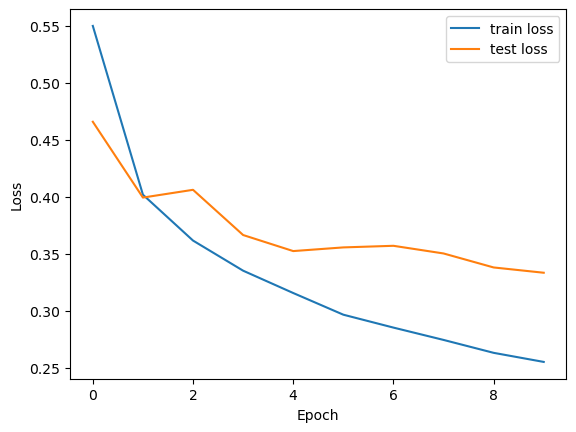

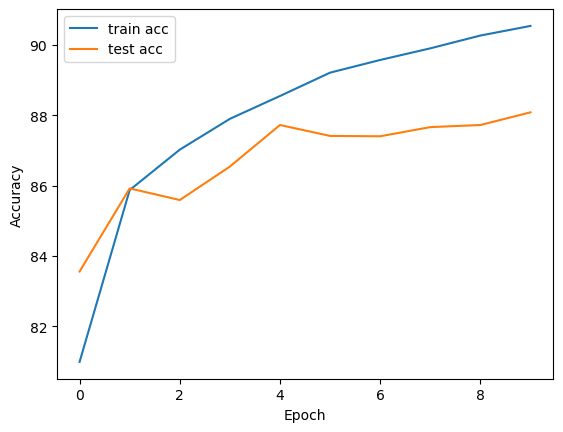

In [15]:
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')

    # 加载模型
    # model = Net()
    # model.load_state_dict(torch.load('model.pth'))

train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion)

In [36]:
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


## 模型调优与参数优化（5‘）
### 修改网络结构，**加入卷积层与池化层**。(2')

In [27]:
class Net1(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=(5, 5)), # [64, 1, 28, 28] -> [64, 3, 24, 24]
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2) # [64, 3, 12, 12]
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, 3),
            nn.Linear(432, 10)
        )

    def forward(self, x):
        x = self.fc(self.convnet(x))
        return x 

### 从包括但不限于以下方面对上述模型进行优化，要求至少尝试**两种**不同方面的优化方式，优化你的模型性能(2')
- 数据增强
- 早停策略
- 激活函数调整
- 正则化
- Dropout
- BatchNorm
- 网络结构调整
- 模型集成
- 超参数调优
- 其他技巧


In [46]:
# 训练模型
def train_and_test(model, train_dataloader, test_dataloader, optimizer, criterion, epochs):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        test_loss, test_acc = test(model, test_dataloader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label='train loss')
    plt.plot(test_loss_list, label='test loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure()
    plt.plot(train_acc_list, label='train acc')
    plt.plot(test_acc_list, label='test acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [77]:
class Net2(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=(5, 5)), # [64, 1, 28, 28] -> [64, 8, 24, 24]
            nn.ReLU(),
            nn.MaxPool2d((2, 2), 2), # [64, 8, 12, 12]
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, 3),
            nn.Linear(1152, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2), # Dropout
            nn.Linear(64, out_channels)
        )
        # BatchNorm
        self.batchnorm = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = self.fc(self.convnet(x))
        x = self.batchnorm(x)

        return x 

In [78]:
model2 = Net2(1, 8, 10)
criterion = nn.CrossEntropyLoss()
# 正则化
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

### 使得模型在FashionMNIST数据集上的准确率达到92%以上。(1')

Epoch 1/10, Train Loss: 0.6015, Train Acc: 84.67%, Test Loss: 0.4256, Test Acc: 86.56%
Epoch 2/10, Train Loss: 0.3927, Train Acc: 88.65%, Test Loss: 0.3363, Test Acc: 88.64%
Epoch 3/10, Train Loss: 0.3269, Train Acc: 89.97%, Test Loss: 0.3241, Test Acc: 89.07%
Epoch 4/10, Train Loss: 0.2886, Train Acc: 90.95%, Test Loss: 0.3233, Test Acc: 89.26%
Epoch 5/10, Train Loss: 0.2594, Train Acc: 91.83%, Test Loss: 0.2981, Test Acc: 89.87%
Epoch 6/10, Train Loss: 0.2419, Train Acc: 92.30%, Test Loss: 0.2961, Test Acc: 90.15%
Epoch 7/10, Train Loss: 0.2185, Train Acc: 92.99%, Test Loss: 0.2908, Test Acc: 90.41%
Epoch 8/10, Train Loss: 0.2004, Train Acc: 93.48%, Test Loss: 0.3149, Test Acc: 89.74%
Epoch 9/10, Train Loss: 0.1875, Train Acc: 93.87%, Test Loss: 0.3202, Test Acc: 89.82%
Epoch 10/10, Train Loss: 0.1694, Train Acc: 94.53%, Test Loss: 0.3252, Test Acc: 89.94%


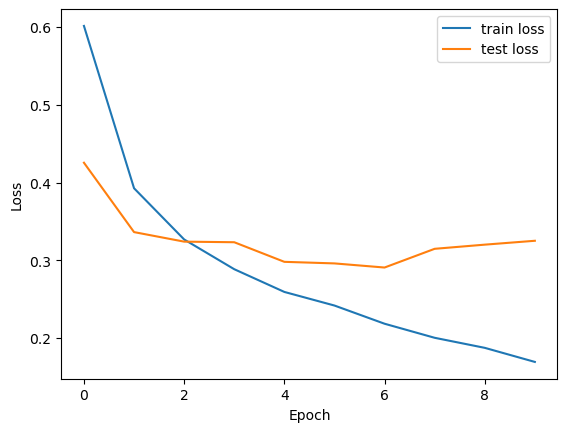

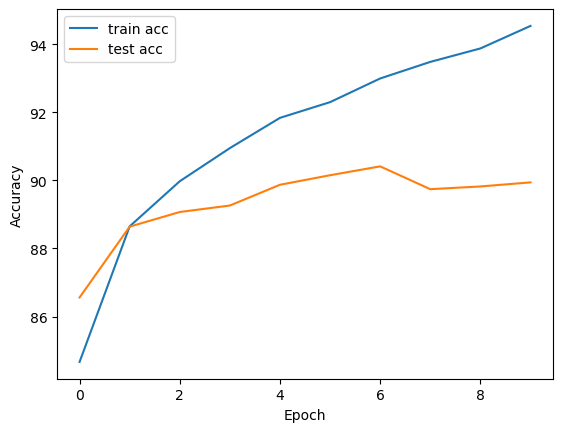

In [79]:
train_and_test(model2, train_dataloader, test_dataloader, optimizer, criterion, 10)